## Train a classification model using a deep convolutional network

In this example, we use only the samples in the dataset labeled as `COVID-19` and in a front position, as shown in the `Explanation` section example.

The `healthy` training samples were extracted from [this Kaggle contest](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge). 

The dataset was divided into two folders `/dataset/sicks` and `/dataset/healthy`, which were in the root folder. Each class having the same number of images of course.

It's a preliminary approach that may improve substantially once the dataset grows enough.

## Imports

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

plt.rcParams["figure.figsize"] = (20,10)

## Global Params

In [2]:
INIT_LR = 1e-4  # learning rate
EPOCHS = 21  # training epochs
BS = 8  # batch size

## Loading data

In [3]:
imagePaths = list(paths.list_images("dataset"))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

### Fixing labels

In [4]:
TEST_SET_SIZE = 0.2

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels); print(labels)
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=TEST_SET_SIZE, stratify=labels, random_state=42)
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
    rotation_range=15,
    fill_mode="nearest")

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 

## Network

In [5]:
baseModel = VGG16(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [6]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

[INFO] compiling model...


## Training

In [7]:
# train the head of the network
print("[INFO] training head...")
H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] training head...
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 17 steps, validate on 36 samples
Epoch 1/21
17/17 [==============================] - 17s 981ms/step - loss: 0.8700 - accuracy: 0.4593 - val_loss: 0.6532 - val_accuracy: 0.4375
Epoch 2/21
17/17 [==============================] - 22s 1s/step - loss: 0.7875 - accuracy: 0.4889 - val_loss: 0.6315 - val_accuracy: 0.4688
Epoch 3/21
17/17 [==============================] - 60s 4s/step - loss: 0.7842 - accuracy: 0.5221 - val_loss: 0.6138 - val_accuracy: 0.5625
Epoch 4/21
17/17 [==============================] - 22s 1s/step - loss: 0.8416 - accuracy: 0.4963 - val_loss: 0.5953 - val_accuracy: 0.5625
Epoch 5/21
17/17 [==============================] - 21s 1s/step - loss: 0.7579 - accuracy: 0.5407 - val_loss: 0.5798 - val_accuracy: 0.5625
Epoch 6/21
17/17 [==============================] - 26s 2s/step - loss: 0.7776 - accuracy: 0.4926 - val_loss: 0.5645 - val_accura

In [8]:
print("[INFO] saving COVID-19 detector model...")
model.save("covid19.model", save_format="h5")

[INFO] saving COVID-19 detector model...


## Evaluation

In [9]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1) # argmax for the predicted probability
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

     healthy       1.00      0.89      0.94        18
       sicks       0.90      1.00      0.95        18

    accuracy                           0.94        36
   macro avg       0.95      0.94      0.94        36
weighted avg       0.95      0.94      0.94        36



In [10]:
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[16  2]
 [ 0 18]]
acc: 0.9444
sensitivity: 0.8889
specificity: 1.0000


## Training visualization

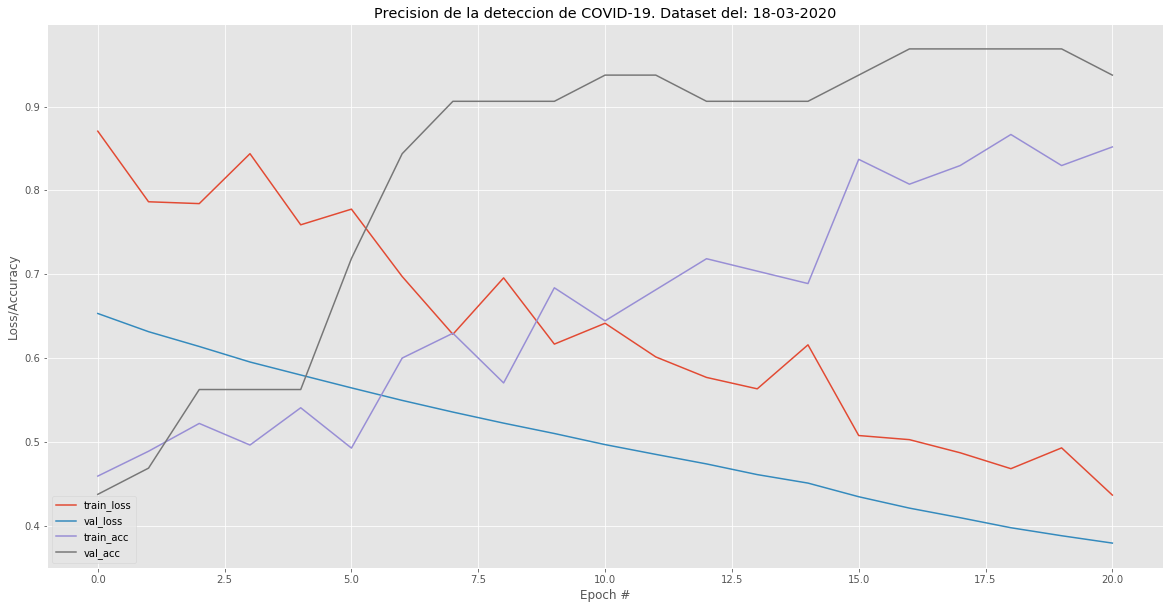

In [11]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Precision de la deteccion de COVID-19. Dataset del: 18-03-2020")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("training_plot.png")

## Lime explanation

In [12]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

100% |########################################################################|
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 1 - predicted: 1


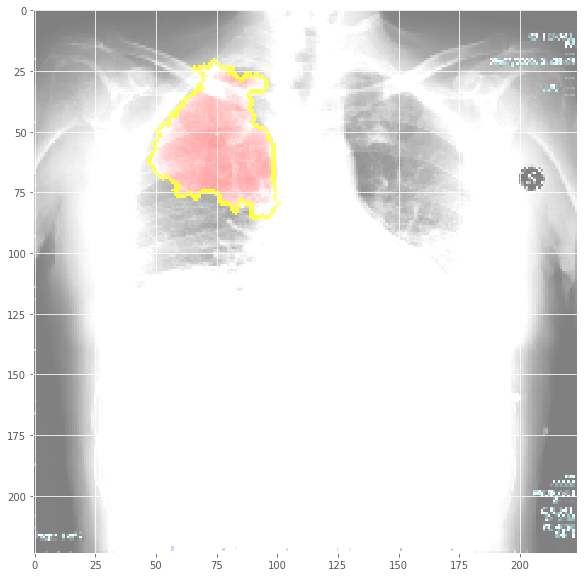

100% |########################################################################|
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 0 - predicted: 0


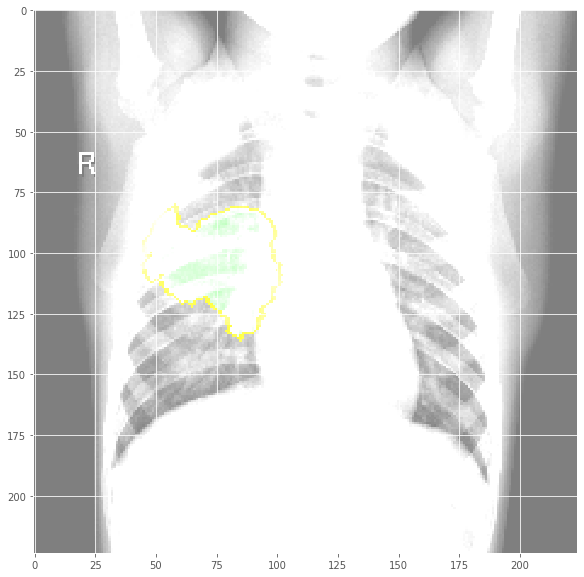

100% |########################################################################|
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 0 - predicted: 1


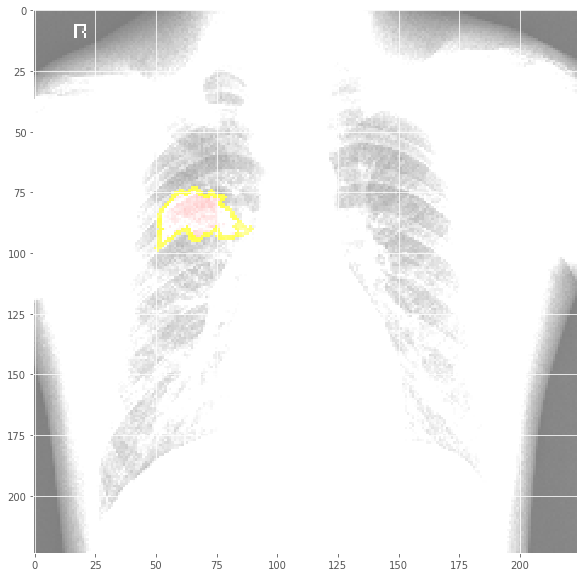

100% |########################################################################|
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 1 - predicted: 1


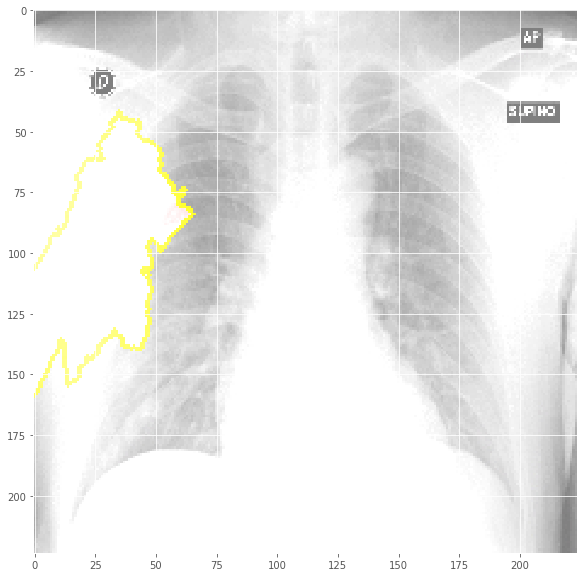

100% |########################################################################|
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 1 - predicted: 1


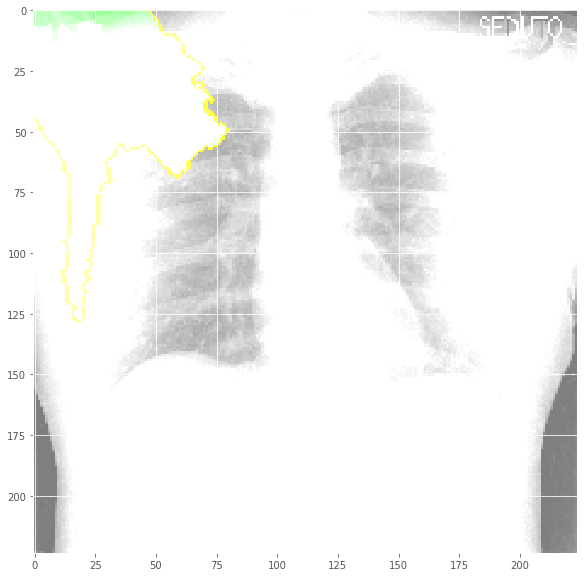

100% |########################################################################|
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 0 - predicted: 0


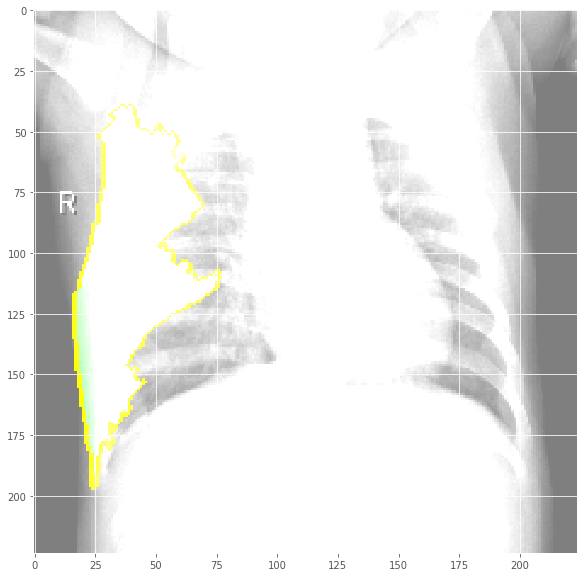

100% |########################################################################|
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 1 - predicted: 1


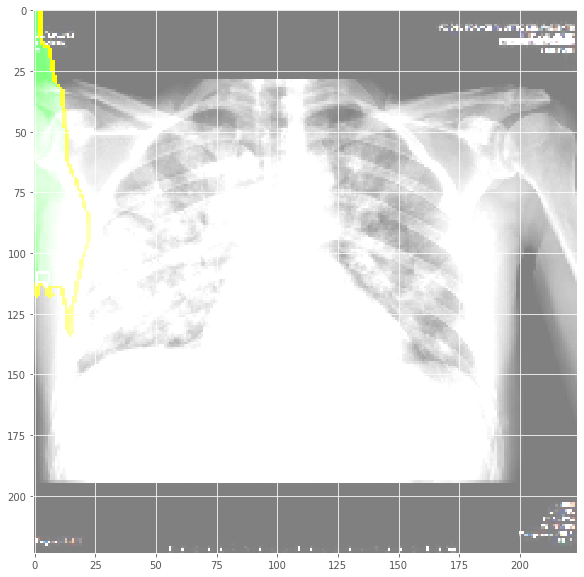

100% |########################################################################|
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 1 - predicted: 1


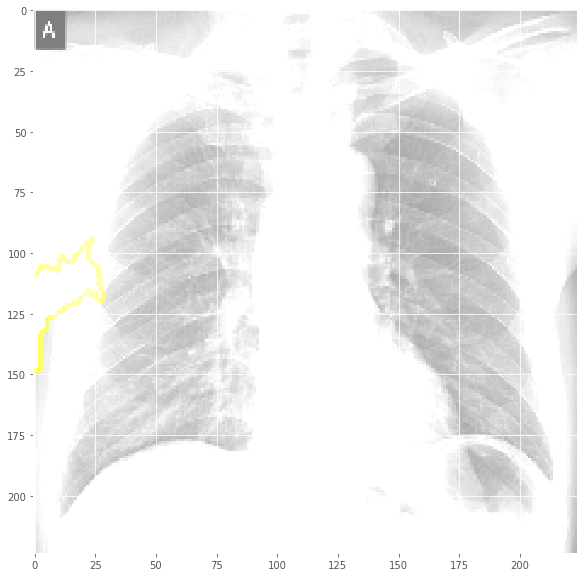

100% |########################################################################|
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 1 - predicted: 1


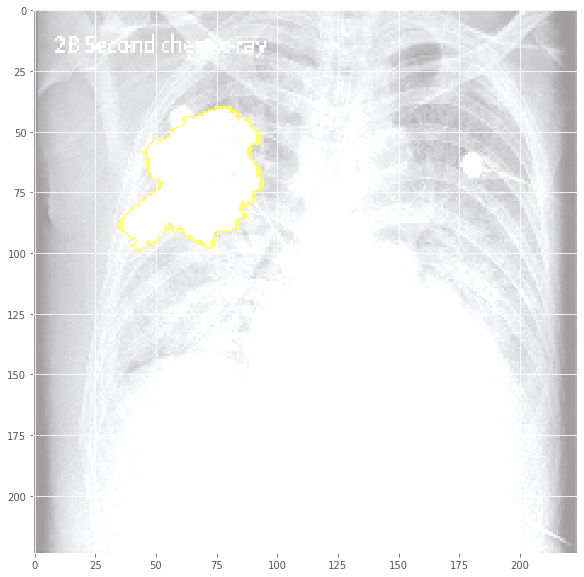

100% |########################################################################|
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 0 - predicted: 0


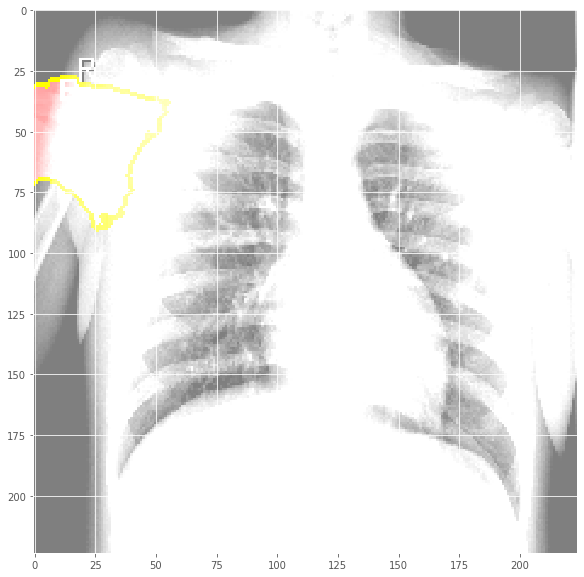

In [13]:
for ind in range(10): 
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(testX[-ind], model.predict,
                                             hide_color=0, num_samples=42)
    print("> label:", testY[ind].argmax(), "- predicted:", predIdxs[ind])
    
    temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], positive_only=False, num_features=1, hide_rest=True)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask)+testX[ind])
    plt.show()